In [77]:
import torch
import torch.nn as nn
import torchvision
from torchinfo import summary
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scripts import data_acquisition, data_setup, engine, plot_loss_curves, utils, model_acquisition
from pathlib import Path
from PIL import Image
from typing import List, Dict, Tuple
import time
import gradio as gr
import random
import importlib
importlib.reload(model_acquisition)

<module 'scripts.model_acquisition' from 'd:\\pytorch\\Experiment-Tracking-ML\\scripts\\model_acquisition.py'>

In [116]:
DATA_PATH = Path("data")
IMAGE_PATH = Path("pizza_steak_sushi_20")
MODEL_PATH = Path("models")
BATCH_SIZE = 32
EPCOHS = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

In [117]:
data_acquisition.acquire_data(image_path=IMAGE_PATH,
                              url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                              zip_name  = "pizza_steak_sushi_20_percent.zip")

Image directory already exists
Done!


## Comparing 2 models

For this section, we will use both the efficientnet and ViT models to train the same dataset and compare the results. We will use the same dataset and the same training parameters for both models. We will also use the same training and validation data for both models. We will then compare the results of both models to see which one performs better.

### Efficientnet

In [118]:
efficientnet_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnet_transforms = efficientnet_weights.transforms()
efficientnet_model = torchvision.models.efficientnet_b2(weights=efficientnet_weights)
for param in efficientnet_model.parameters():
    param.requires_grad = False

In [119]:
summary(model = efficientnet_model, 
        input_size = (32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 1000]                --                        False
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1408, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential: 

In [120]:
efficientnet_model.classifier = nn.Sequential(nn.Dropout(p=0.3, inplace=True),
                                              nn.Linear(in_features=1408, out_features=3, bias=True),
                                              )    

In [121]:
summary(model = efficientnet_model, 
        input_size = (32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1408, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential

In [122]:
effnet_traindataloader, effnet_testdataloader, class_names = data_setup.create_dataloaders(
                                                                                            data_dir = DATA_PATH/IMAGE_PATH,
                                                                                            batch_size = BATCH_SIZE,
                                                                                            train_transform = effnet_transforms,
                                                                                            test_transform = effnet_transforms,
                                                                                            num_workers = 0
)

In [123]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet_model.parameters(), lr=0.001)

In [124]:
history_effnet , all_preds_effnet, all_labels_effnet, effnetwriter = engine.train(model = efficientnet_model,
                                                                                 data_name = "pizza_steak_sushi",
                                                                                 train_dataloader = effnet_traindataloader,
                                                                                 val_dataloader= effnet_testdataloader,
                                                                                 epochs = EPCOHS*2,
                                                                                 model_name = "efficientnet_b2",
                                                                                 loss_fn = loss_fn,
                                                                                 optimizer = optimizer,
                                                                                 device = device
                                                                                )

  5%|▌         | 1/20 [00:04<01:30,  4.78s/it]

Epoch 1 of 20, Train Loss: 0.9563, Train Acc: 0.5875, Val Loss: 0.7277, Val Acc: 0.9165


 10%|█         | 2/20 [00:09<01:22,  4.57s/it]

Epoch 2 of 20, Train Loss: 0.6993, Train Acc: 0.8042, Val Loss: 0.5750, Val Acc: 0.9199


 15%|█▌        | 3/20 [00:13<01:14,  4.39s/it]

Epoch 3 of 20, Train Loss: 0.5511, Train Acc: 0.8812, Val Loss: 0.4966, Val Acc: 0.9347


 20%|██        | 4/20 [00:17<01:08,  4.31s/it]

Epoch 4 of 20, Train Loss: 0.5361, Train Acc: 0.8562, Val Loss: 0.4131, Val Acc: 0.9381


 25%|██▌       | 5/20 [00:21<01:04,  4.29s/it]

Epoch 5 of 20, Train Loss: 0.4197, Train Acc: 0.8875, Val Loss: 0.3771, Val Acc: 0.9534


 30%|███       | 6/20 [00:25<00:59,  4.24s/it]

Epoch 6 of 20, Train Loss: 0.3872, Train Acc: 0.9208, Val Loss: 0.3615, Val Acc: 0.9568


 35%|███▌      | 7/20 [00:30<00:55,  4.25s/it]

Epoch 7 of 20, Train Loss: 0.4122, Train Acc: 0.8917, Val Loss: 0.3168, Val Acc: 0.9506


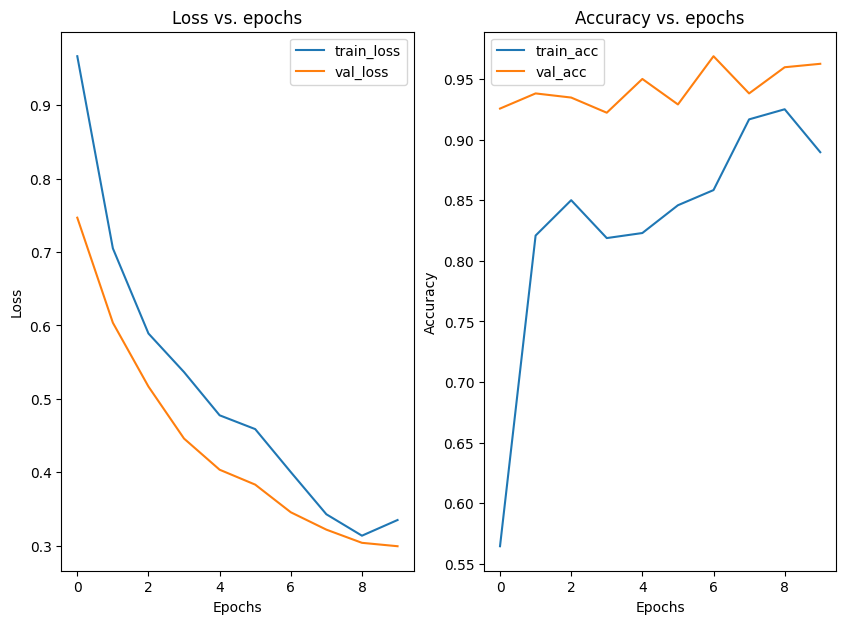

In [ ]:
plot_loss_curves.plot_loss_curves(history = history_effnet)

In [12]:
utils.save_model(model = efficientnet_model,
                 target_dir = Path("models"),
                 model_name = "efficientnet_b2_new")

effnet_model_size = Path("models/efficientnet_b2.pth").stat().st_size//(1024 * 1024)
print(f"Model size is {effnet_model_size} MB")

Saving model to models\efficientnet_b2.pth
Model size is 29 MB


In [13]:
efficientnet_paramaeters = sum(p.numel() for p in efficientnet_model.parameters())
print(f"Model has {efficientnet_paramaeters} parameters")

Model has 7705221 parameters


In [14]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": history_effnet["val_loss"][-1],
                  "test_acc": history_effnet["val_acc"][-1],
                  "number_of_parameters": efficientnet_paramaeters,
                  "model_size (MB)": effnet_model_size}
print(effnetb2_stats)

{'test_loss': 0.2993056118488312, 'test_acc': 0.9625, 'number_of_parameters': 7705221, 'model_size (MB)': 29}


### ViT

In [15]:
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_transforms = vit_weights.transforms()
vit_model = torchvision.models.vit_b_16(weights=vit_weights)
for param in vit_model.parameters():
    param.requires_grad = False

In [16]:
summary(model = vit_model, 
        input_size = (32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],)

c:\Users\warre\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\activation.py:1196: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._native_multi_head_attention(


Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
VisionTransformer                             [32, 3, 224, 224]         [32, 1000]                768                       False
├─Conv2d: 1-1                                 [32, 3, 224, 224]         [32, 768, 14, 14]         (590,592)                 False
├─Encoder: 1-2                                [32, 197, 768]            [32, 197, 768]            151,296                   False
│    └─Dropout: 2-1                           [32, 197, 768]            [32, 197, 768]            --                        --
│    └─Sequential: 2-2                        [32, 197, 768]            [32, 197, 768]            --                        False
│    │    └─EncoderBlock: 3-1                 [32, 197, 768]            [32, 197, 768]            (7,087,872)               False
│    │    └─EncoderBlock: 3-2                 [32, 197, 768]            [32, 197, 768]   

In [17]:
vit_model.heads = nn.Sequential(nn.Linear(in_features=768, out_features=3, bias=True))

In [18]:
summary(model = vit_model, 
        input_size = (32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
VisionTransformer                             [32, 3, 224, 224]         [32, 3]                   768                       Partial
├─Conv2d: 1-1                                 [32, 3, 224, 224]         [32, 768, 14, 14]         (590,592)                 False
├─Encoder: 1-2                                [32, 197, 768]            [32, 197, 768]            151,296                   False
│    └─Dropout: 2-1                           [32, 197, 768]            [32, 197, 768]            --                        --
│    └─Sequential: 2-2                        [32, 197, 768]            [32, 197, 768]            --                        False
│    │    └─EncoderBlock: 3-1                 [32, 197, 768]            [32, 197, 768]            (7,087,872)               False
│    │    └─EncoderBlock: 3-2                 [32, 197, 768]            [32, 197, 768] 

In [19]:
vit_traindataloader, vit_testdataloader, class_names = data_setup.create_dataloaders(
                                                                                        data_dir = DATA_PATH/IMAGE_PATH,
                                                                                        batch_size = BATCH_SIZE,
                                                                                        train_transform = vit_transforms,
                                                                                        test_transform = vit_transforms,
                                                                                        num_workers = 0
)

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=0.001)

In [21]:
history_vit , all_preds_vit, all_labels_vit, vitwriter = engine.train(model = vit_model,
                                                                     data_name = "pizza_steak_sushi",
                                                                     train_dataloader = vit_testdataloader,
                                                                     val_dataloader= vit_testdataloader,
                                                                     epochs = EPCOHS,
                                                                     model_name = "vit_b_16",
                                                                     loss_fn = loss_fn,
                                                                     optimizer = optimizer,
                                                                     device = device
                                                        )

 10%|█         | 1/10 [00:03<00:32,  3.62s/it]

Epoch 1 of 10, Train Loss: 1.1555, Train Acc: 0.3869, Val Loss: 0.7883, Val Acc: 0.6773


 20%|██        | 2/10 [00:07<00:28,  3.59s/it]

Epoch 2 of 10, Train Loss: 0.6524, Train Acc: 0.7477, Val Loss: 0.5079, Val Acc: 0.8307


 30%|███       | 3/10 [00:10<00:25,  3.58s/it]

Epoch 3 of 10, Train Loss: 0.4117, Train Acc: 0.9193, Val Loss: 0.3387, Val Acc: 0.9443


 40%|████      | 4/10 [00:14<00:21,  3.58s/it]

Epoch 4 of 10, Train Loss: 0.2806, Train Acc: 0.9659, Val Loss: 0.2410, Val Acc: 0.9722


 50%|█████     | 5/10 [00:17<00:17,  3.59s/it]

Epoch 5 of 10, Train Loss: 0.2082, Train Acc: 0.9875, Val Loss: 0.1840, Val Acc: 0.9875


 60%|██████    | 6/10 [00:21<00:14,  3.58s/it]

Epoch 6 of 10, Train Loss: 0.1652, Train Acc: 0.9875, Val Loss: 0.1482, Val Acc: 0.9875


 70%|███████   | 7/10 [00:25<00:10,  3.59s/it]

Epoch 7 of 10, Train Loss: 0.1366, Train Acc: 0.9875, Val Loss: 0.1236, Val Acc: 0.9938


 80%|████████  | 8/10 [00:28<00:07,  3.59s/it]

Epoch 8 of 10, Train Loss: 0.1159, Train Acc: 0.9938, Val Loss: 0.1056, Val Acc: 1.0000


 90%|█████████ | 9/10 [00:32<00:03,  3.57s/it]

Epoch 9 of 10, Train Loss: 0.1002, Train Acc: 1.0000, Val Loss: 0.0921, Val Acc: 1.0000


100%|██████████| 10/10 [00:35<00:00,  3.58s/it]

Epoch 10 of 10, Train Loss: 0.0881, Train Acc: 1.0000, Val Loss: 0.0818, Val Acc: 1.0000


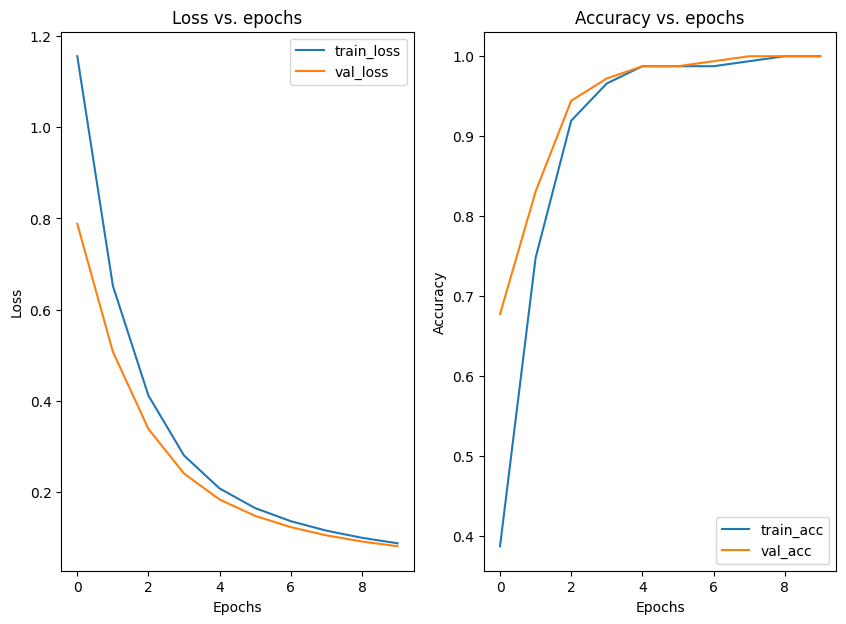

In [22]:
plot_loss_curves.plot_loss_curves(history = history_vit)

In [23]:
utils.save_model(model = vit_model,
                 target_dir = Path("models"),
                 model_name = "vit_b_16")

vit_model_size = Path("models/vit_b_16.pth").stat().st_size//(1024 * 1024)
print(f"Model size is {vit_model_size} MB")

Saving model to models\vit_b_16.pth
Model size is 327 MB


In [24]:
vit_paramaeters = sum(p.numel() for p in vit_model.parameters())
print(f"Model has {vit_paramaeters} parameters")

Model has 85800963 parameters


In [25]:
# Create a dictionary with EffNetB2 statistics
vit_b_16_stats = {"test_loss": history_vit["val_loss"][-1],
                  "test_acc": history_vit["val_acc"][-1],
                  "number_of_parameters": vit_paramaeters,
                  "model_size (MB)": vit_model_size}
print(vit_b_16_stats)

{'test_loss': 0.08175139501690865, 'test_acc': 1.0, 'number_of_parameters': 85800963, 'model_size (MB)': 327}


### Performing inference and timing on coth models

In [26]:
TEST_DIR = DATA_PATH/IMAGE_PATH/"test"
test_images = list(TEST_DIR.glob("*/*.jpg"))
print(test_images[:5])

[WindowsPath('data/pizza_steak_sushi_20/test/pizza/1001116.jpg'), WindowsPath('data/pizza_steak_sushi_20/test/pizza/1032754.jpg'), WindowsPath('data/pizza_steak_sushi_20/test/pizza/1067986.jpg'), WindowsPath('data/pizza_steak_sushi_20/test/pizza/129666.jpg'), WindowsPath('data/pizza_steak_sushi_20/test/pizza/1315645.jpg')]


In [27]:
def pred_and_time(image_paths: Path,
                  model: nn.Module,
                  device: torch.device,
                  transform: torchvision.transforms,
                  class_names: List[str]) -> List[Dict]:
    """ Predict the class of an image using a trained model and record the time it takes
    Args:
    image_paths: List of paths to images
    model: Trained model
    device: Device to run the model on
    transform: Transformation to apply to the images
    class_names: The class names of the dataset
    Returns:
    List of dictionaries containing the image path, actual class, predicted class, predicted probability, inference time and if the prediction was correct
    """
    results = []
    model = model.to(device)
    model.eval()
    with torch.inference_mode():
        for image in image_paths:
            start_time = time.time()
            img = Image.open(image)
            img = transform(img).unsqueeze(0).to(device)
            pred_logits = model(img)
            pred_probs = torch.softmax(pred_logits, dim=1)
            pred_class = class_names[torch.argmax(pred_probs)]
            pred_class_prob = torch.max(pred_probs)
            pred_correct = pred_class == image.parent.stem
            end_time = time.time()
            results.append({"image_path": image.name,
                            "actual_class": image.parent.stem,
                            "predicted_class": pred_class,
                            "predicted_probability": pred_class_prob,
                            "inference_time": end_time - start_time,
                            "correct": pred_correct})
    return results

In [28]:
device = "cpu" # Use CPU as not all devices will have a CUDA compatible GPU
efficientnet_results = pred_and_time(image_paths = test_images,
                                     model = efficientnet_model,
                                     device = device,
                                     transform = effnet_transforms,
                                     class_names = class_names)


vit_results = pred_and_time(image_paths = test_images,
                            model = vit_model,
                            device = device,
                            transform = vit_transforms,
                            class_names = class_names)

In [29]:
efficientnet_dataframe = pd.DataFrame(efficientnet_results)
vit_dataframe = pd.DataFrame(vit_results)

print(efficientnet_dataframe.head())
print(vit_dataframe.head())

    image_path actual_class predicted_class predicted_probability  \
0  1001116.jpg        pizza           pizza        tensor(0.9874)   
1  1032754.jpg        pizza           pizza        tensor(0.5164)   
2  1067986.jpg        pizza           pizza        tensor(0.9918)   
3   129666.jpg        pizza           pizza        tensor(0.6228)   
4  1315645.jpg        pizza           pizza        tensor(0.7586)   

   inference_time  correct  
0        0.114929     True  
1        0.084134     True  
2        0.076416     True  
3        0.067533     True  
4        0.069079     True  
    image_path actual_class predicted_class predicted_probability  \
0  1001116.jpg        pizza           pizza        tensor(0.9922)   
1  1032754.jpg        pizza           pizza        tensor(0.9713)   
2  1067986.jpg        pizza           pizza        tensor(0.9866)   
3   129666.jpg        pizza           pizza        tensor(0.8925)   
4  1315645.jpg        pizza           pizza        tensor(0.7389) 

In [30]:
print(f"Efficientnet results \n{efficientnet_dataframe.correct.value_counts()}\n")
print(f"ViT results \n{vit_dataframe.correct.value_counts()}")

Efficientnet results 
correct
True     144
False      6
Name: count, dtype: int64

ViT results 
correct
True    150
Name: count, dtype: int64


In [31]:
average_efficientnet_inference_time = efficientnet_dataframe.inference_time.mean()
average_vit_ingference_time = vit_dataframe.inference_time.mean()

print(f"Average EfficientNet inference time: {average_efficientnet_inference_time:.5f} seconds")
print(f"Average ViT inference time: {average_vit_ingference_time:.5f} seconds")

Average EfficientNet inference time: 0.07253 seconds
Average ViT inference time: 0.12392 seconds


In [32]:
effnetb2_stats["average_inference_time"] = average_efficientnet_inference_time
vit_b_16_stats["average_inference_time"] = average_vit_ingference_time

In [33]:
summary_df = pd.DataFrame([effnetb2_stats, vit_b_16_stats])
summary_df["model"] = ["EfficientNet B2", "ViT B16"]
summary_df["test_acc"] = round(summary_df["test_acc"] * 100, 2)
print(summary_df)

   test_loss  test_acc  number_of_parameters  model_size (MB)  \
0   0.299306     96.25               7705221               29   
1   0.081751    100.00              85800963              327   

   average_inference_time            model  
0                0.072532  EfficientNet B2  
1                0.123917          ViT B16  


In [34]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(summary_df.set_index("model").loc["ViT B16"] / summary_df.set_index("model").loc["EfficientNet B2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),average_inference_time
ViT to EffNetB2 ratios,0.273137,1.038961,11.135432,11.275862,1.708452


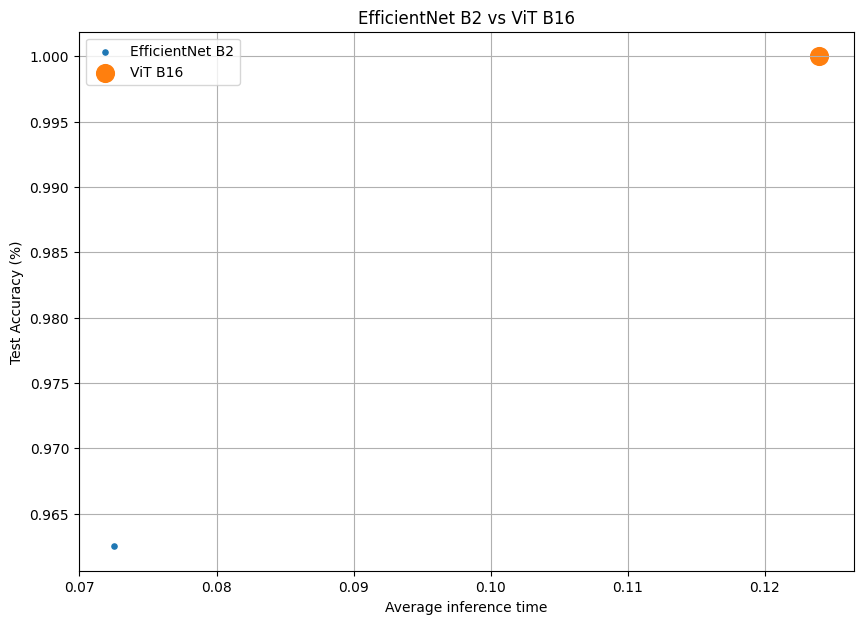

In [35]:
plt.figure(figsize=(10, 7))
plt.scatter(x = effnetb2_stats["average_inference_time"], y = effnetb2_stats["test_acc"], label = "EfficientNet B2", s = effnetb2_stats["model_size (MB)"] // 2)
plt.scatter(x = vit_b_16_stats["average_inference_time"], y = vit_b_16_stats["test_acc"], label = "ViT B16", s = vit_b_16_stats["model_size (MB)"] // 2)
plt.title("EfficientNet B2 vs ViT B16")
plt.xlabel("Average inference time")
plt.ylabel("Test Accuracy (%)")
plt.grid()
plt.legend()
plt.show()

### Creating a Gradio demo

In [78]:
deploymentmodel = model_acquisition.EfficientNetb2(num_classes=len(class_names),
                                                   state_dict_path="models/efficientnet_b2.pth").to("cpu")

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [111]:
def predict(img) -> Tuple[Dict, float]: 
    """Takes an image as an input and returns the predicted class and the probability of the prediction"""
    start_time = time.time()
    img = deploymentmodel.transforms(img).unsqueeze(0)
    deploymentmodel.eval()
    with torch.inference_mode():
        pred_logits = deploymentmodel(img)
        pred_probs = torch.softmax(pred_logits, dim=1)
        print(pred_probs)
    pred_probs_and_labels = {class_names[i]: pred_probs[0][i] for i in range(len(class_names))}
    end_time = time.time()
    return pred_probs_and_labels, end_time - start_time

In [112]:
random_image = random.choice(test_images)
img = Image.open(random_image)
print(predict(img))

tensor([[0.0625, 0.1457, 0.7918]])
({'pizza': tensor(0.0625), 'steak': tensor(0.1457), 'sushi': tensor(0.7918)}, 0.07197165489196777)


In [113]:
# Create example list for gradio demo

example_list = [str(file_path) for file_path in random.sample(test_images, 5)]
print(example_list)

['data\\pizza_steak_sushi_20\\test\\pizza\\129666.jpg', 'data\\pizza_steak_sushi_20\\test\\steak\\48208.jpg', 'data\\pizza_steak_sushi_20\\test\\pizza\\2549661.jpg', 'data\\pizza_steak_sushi_20\\test\\pizza\\1315645.jpg', 'data\\pizza_steak_sushi_20\\test\\sushi\\3834718.jpg']


In [114]:
demo = gr.Interface(fn = predict,
                    inputs =gr.Image(type="pil"),
                    outputs =[gr.Label(num_top_classes=3, label="Predictions"), gr.Number(label="Prediction time (s)")],
                    examples = example_list,
                    title = "EfficientNet B2 Image Classifier",
                    description="This is an image classifier which uses an EfficientNet B2 model to classify images of pizza, steak and sushi"
                    )
demo.launch()

Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


tensor([[0.6548, 0.1972, 0.1480]])
tensor([[0.6548, 0.1972, 0.1480]])
tensor([[0.3205, 0.0740, 0.6055]])
tensor([[0.3960, 0.3453, 0.2587]])
tensor([[0.4895, 0.2891, 0.2214]])


Traceback (most recent call last):
  File "c:\Users\warre\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\queueing.py", line 541, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\warre\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\route_utils.py", line 276, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\warre\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\blocks.py", line 1928, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\warre\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\blocks.py", line 1514, in call_function
    prediction = await anyio.to_thread.run_sync(
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\warre\AppData\Local\Programs\Python\Python312\Lib\sit

tensor([[0.3509, 0.3216, 0.3275]])
tensor([[0.3205, 0.0740, 0.6055]])
